In [1]:
import numpy as np
import scipy.io as sio 
import scipy.signal as sig
from matplotlib import pyplot as plt
%matplotlib inline
dat = sio.loadmat('/Users/soumilhooda/Documents/BCI/Data/BCICIV_4_mat/sub2_comp.mat',struct_as_record = True)

In [2]:
train_data = dat['train_data']
train_dg = dat['train_dg']
samples,channels = train_data.shape
tt = 400 #Sampling time
sf = 1000 #Sampling frequency 
channel_data = np.transpose(train_data,(1,0))
finger_data = np.transpose(train_dg,(1,0))

In [3]:
# FIR filter 
def bandPass(signal,fl,fh):
    taps = 505
    band = np.array([fl,fh])
    h = sig.firwin(taps,band,fs=sf,pass_zero='bandpass')
    output = np.convolve(signal,h,mode='same')
    return output

In [4]:
# Amplitude modulation : 
def AM(signal):
    cur = 0
    output = []
    for i in range(samples):
        if(i and i % 40 == 0):
            output.append(cur)
            cur = 0
        cur += signal[i]**2
    output.append(cur)
         
    return output

In [5]:
# Seperate channel_data into frequency bands : 
# sub_band = [bandPass(x,1,60) for x in channel_data]
# gamma_band = [bandPass(x,60,100) for x in channel_data]
# fast_gamma_band = [bandPass(x,100,200) for x in channel_data]

In [5]:
# Perform amplitude modulation on each band :
# sub_band = np.array([AM(x) for x in sub_band])
# gamma_band = np.array([AM(x) for x in gamma_band])
# fast_gamma_band = np.array([AM(x) for x in fast_gamma_band])
full_band = [AM(x) for x in channel_data]

In [6]:
# Finger data downsampling : 
finger_data_ds = [None]*5
for i in range(5):
    finger_data_ds[i] = [finger_data[i][j] for j in range(0,samples,40)]

In [7]:
# State assignment : (0 : rest, 1-5 finger flexed)
dsamples = len(finger_data_ds[0])
states = [None]*dsamples
threshold_1,threshold_2  = 2.0,1.0
for i in range(dsamples):
    flex,rest = 0,0
    for j in range(5):
        if finger_data_ds[j][i] >= threshold_1:
            states[i] = j + 1
            flex += 1
        elif finger_data_ds[j][i] < threshold_2:
            rest += 1
    if states[i] == None:
        if rest:
            states[i] = 0

In [8]:
# Zero restriction : 
import random 
ends = []
z_buckets = []
cur = 0
for i in range(len(states)):
    if(states[i] == 0):
        cur += 1
    else:
        if(cur == 0):
            continue
        z_buckets.append(cur)
        ends.append(i-1)
        cur = 0

if(cur):
    z_buckets.append(cur)
    ends.append(len(states)-1)

keeps = []
for i in range(len(ends)):
    start = ends[i] - z_buckets[i] + 1
    while(1):
        rl = random.sample(range(start,ends[i]),3)
        rl = sorted(rl)
        if(rl[0] == rl[1] or rl[1] == rl[2]):
            continue
        else:
            break

    for e in rl:
        keeps.append(e)


In [9]:
# Fresh data : 
new_ch = []
for i in range(len(full_band)):
    curch = []
    idx = 0
    for j in range(len(states)):
        if(states[j]):
            curch.append(full_band[i][j])
        else:
            if(idx < len(keeps) and j == keeps[idx]):
                curch.append(full_band[i][j])
                idx += 1
    new_ch.append(curch)

new_states = []
idx = 0
for i in range(len(states)):
    if(states[i]):
        new_states.append(states[i])
    else:
        if(idx < len(keeps) and i == keeps[idx]):
            new_states.append(states[i])
            idx += 1

In [10]:
new_ch_np = np.array(new_ch)
new_states_np = np.array(new_states)

In [11]:
new_states_np = new_states_np.reshape(len(new_states_np), 1)

from sklearn.preprocessing import OneHotEncoder

Fingers_Subject2_OneHot = OneHotEncoder(sparse=False).fit_transform(new_states_np)
print(Fingers_Subject2_OneHot)

[[1. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0.]
 ...
 [1. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0.]]


In [12]:
from sklearn.preprocessing import Normalizer

Sub2_AllBand = Normalizer().fit(new_ch_np).transform(new_ch_np)
print(Sub2_AllBand)

[[6.38219722e-05 1.04276522e-02 5.89806183e-04 ... 6.71020130e-03
  8.58947257e-03 2.57775348e-03]
 [5.31708016e-04 1.10372674e-02 4.72651872e-03 ... 3.49129969e-03
  9.16683231e-03 1.20029529e-03]
 [1.54263975e-02 1.13069675e-03 2.31055411e-03 ... 1.83690376e-03
  9.91706623e-04 1.03333415e-02]
 ...
 [8.65034828e-04 3.33163743e-03 3.89885204e-03 ... 2.25230769e-03
  1.55148426e-02 6.52744517e-03]
 [4.12390065e-05 1.36630534e-02 1.51630818e-03 ... 1.06973154e-03
  1.18042174e-03 2.66149590e-03]
 [1.45412127e-02 1.62473962e-03 1.01663790e-03 ... 1.26477789e-03
  4.46390827e-03 2.05360553e-03]]


In [13]:
print(Sub2_AllBand.shape)
print(Fingers_Subject2_OneHot.shape)

(48, 2909)
(2909, 6)


In [14]:
Sub2_AllBand = Sub2_AllBand.T
Sub2_AllBand = Sub2_AllBand.reshape(len(Sub2_AllBand),1,len(Sub2_AllBand[0]))
print(Sub2_AllBand.shape)

(2909, 1, 48)


In [20]:
import tensorflow
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.regularizers import l2
import numpy

model = keras.Sequential()
model.add(layers.LSTM(48,  input_shape=(1,48),activation = "relu"))
model.add(layers.Dense(32, activation = "relu"))
model.add(layers.Dense(6, activation='softmax'))

opt = keras.optimizers.Adam(learning_rate=0.005)
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['mse'])
model.summary()

history = model.fit(Sub2_AllBand, Fingers_Subject2_OneHot, batch_size = 3, epochs=10, validation_split=0.2)

predictions = model.predict(Sub2_AllBand)
print("Predicted values are: ", predictions)
np.savetxt('DownsampledModel_NorPred.txt',predictions)
Corrected_Pred = numpy.argmax(predictions, axis = 1)
print(Corrected_Pred)
np.savetxt('DownsampledModel_Pred.txt',Corrected_Pred)

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 48)                18624     
_________________________________________________________________
dense_8 (Dense)              (None, 32)                1568      
_________________________________________________________________
dense_9 (Dense)              (None, 6)                 198       
Total params: 20,390
Trainable params: 20,390
Non-trainable params: 0
_________________________________________________________________
Train on 2327 samples, validate on 582 samples
Epoch 1/10
2327/2327 [==============================] - 8s 3ms/sample - loss: 1.7703 - mse: 0.1377 - val_loss: 1.7341 - val_mse: 0.1356
Epoch 2/10
2327/2327 [==============================] - 4s 2ms/sample - loss: 1.7373 - mse: 0.1360 - val_loss: 1.7057 - val_mse: 0.1346
Epoch 3/10
2327/2327 [==============================] - 5s 2m

In [32]:
model2 = keras.Sequential()
model2.add(layers.LSTM(48,  input_shape=(1,48),activation = "relu"))
model2.add(layers.Dense(6, activation='softmax'))

opt = keras.optimizers.Adam(learning_rate=0.005)
model2.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['mse'])
model2.summary()

history = model2.fit(Sub2_AllBand, Fingers_Subject2_OneHot, batch_size = 3, epochs=10, validation_split=0.2)

predictions2 = model2.predict(Sub2_AllBand)
print("Predicted values are: ", predictions2)
np.savetxt('DownsampledModel2_NorPred.txt',predictions2)
Corrected_Pred2 = numpy.argmax(predictions2, axis = 1)
print(Corrected_Pred2)
np.savetxt('DownsampledModel2_Pred.txt',Corrected_Pred2)

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_6 (LSTM)                (None, 48)                18624     
_________________________________________________________________
dense_13 (Dense)             (None, 6)                 294       
Total params: 18,918
Trainable params: 18,918
Non-trainable params: 0
_________________________________________________________________
Train on 2327 samples, validate on 582 samples
Epoch 1/10
2327/2327 [==============================] - 9s 4ms/sample - loss: 1.7649 - mse: 0.1374 - val_loss: 1.7111 - val_mse: 0.1345
Epoch 2/10
2327/2327 [==============================] - 9s 4ms/sample - loss: 1.7082 - mse: 0.1343 - val_loss: 1.7075 - val_mse: 0.1344
Epoch 3/10
2327/2327 [==============================] - 6s 3ms/sample - loss: 1.6388 - mse: 0.1304 - val_loss: 1.6915 - val_mse: 0.1335
Epoch 4/10
2327/2327 [==============================] - 5

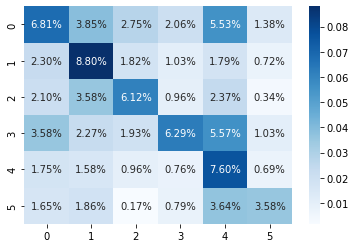

In [33]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

conf2 = confusion_matrix(new_states_np, Corrected_Pred2)
sns.heatmap(conf2/np.sum(conf2), annot=True, fmt='.2%', cmap='Blues')
plt.show()

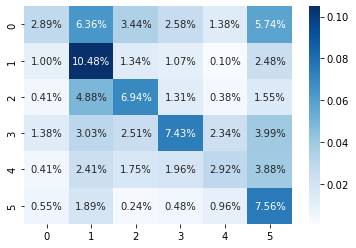

In [34]:
conf = confusion_matrix(new_states_np, Corrected_Pred)
sns.heatmap(conf/np.sum(conf), annot=True, fmt='.2%', cmap='Blues')
plt.show()

In [35]:
model3 = keras.Sequential()
model3.add(layers.LSTM(32,  input_shape=(1,48),activation = "relu"))
model3.add(layers.Dense(6, activation='softmax'))

opt = keras.optimizers.Adam(learning_rate=0.005)
model3.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['mse'])
model3.summary()

history = model3.fit(Sub2_AllBand, Fingers_Subject2_OneHot, batch_size = 3, epochs=10, validation_split=0.2)

predictions3 = model3.predict(Sub2_AllBand)
print("Predicted values are: ", predictions3)
np.savetxt('DownsampledModel3_NorPred.txt',predictions3)
Corrected_Pred3 = numpy.argmax(predictions3, axis = 1)
print(Corrected_Pred3)
np.savetxt('DownsampledModel3_Pred.txt',Corrected_Pred3)

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_7 (LSTM)                (None, 32)                10368     
_________________________________________________________________
dense_14 (Dense)             (None, 6)                 198       
Total params: 10,566
Trainable params: 10,566
Non-trainable params: 0
_________________________________________________________________
Train on 2327 samples, validate on 582 samples
Epoch 1/10
2327/2327 [==============================] - 14s 6ms/sample - loss: 1.7716 - mse: 0.1377 - val_loss: 1.7321 - val_mse: 0.1355
Epoch 2/10
2327/2327 [==============================] - 9s 4ms/sample - loss: 1.7357 - mse: 0.1358 - val_loss: 1.7146 - val_mse: 0.1348
Epoch 3/10
2327/2327 [==============================] - 6s 3ms/sample - loss: 1.6733 - mse: 0.1324 - val_loss: 1.7080 - val_mse: 0.1345
Epoch 4/10
2327/2327 [==============================] - 

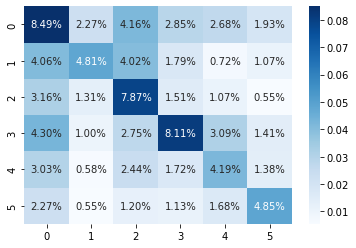

In [36]:
conf3 = confusion_matrix(new_states_np, Corrected_Pred3)
sns.heatmap(conf3/np.sum(conf3), annot=True, fmt='.2%', cmap='Blues')
plt.show()

In [37]:
model4 = keras.Sequential()
model4.add(layers.LSTM(24,  input_shape=(1,48),activation = "relu"))
model4.add(layers.Dense(6, activation='softmax'))

opt = keras.optimizers.Adam(learning_rate=0.005)
model4.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['mse'])
model4.summary()

history = model4.fit(Sub2_AllBand, Fingers_Subject2_OneHot, batch_size = 3, epochs=10, validation_split=0.2)

predictions4 = model4.predict(Sub2_AllBand)
print("Predicted values are: ", predictions4)
np.savetxt('DownsampledModel4_NorPred.txt',predictions4)
Corrected_Pred4 = numpy.argmax(predictions4, axis = 1)
print(Corrected_Pred4)
np.savetxt('DownsampledModel4_Pred.txt',Corrected_Pred4)

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_8 (LSTM)                (None, 24)                7008      
_________________________________________________________________
dense_15 (Dense)             (None, 6)                 150       
Total params: 7,158
Trainable params: 7,158
Non-trainable params: 0
_________________________________________________________________
Train on 2327 samples, validate on 582 samples
Epoch 1/10
2327/2327 [==============================] - 10s 4ms/sample - loss: 1.7657 - mse: 0.1375 - val_loss: 1.7344 - val_mse: 0.1357
Epoch 2/10
2327/2327 [==============================] - 6s 3ms/sample - loss: 1.7235 - mse: 0.1351 - val_loss: 1.7160 - val_mse: 0.1350
Epoch 3/10
2327/2327 [==============================] - 7s 3ms/sample - loss: 1.6692 - mse: 0.1323 - val_loss: 1.7108 - val_mse: 0.1346
Epoch 4/10
2327/2327 [==============================] - 7s

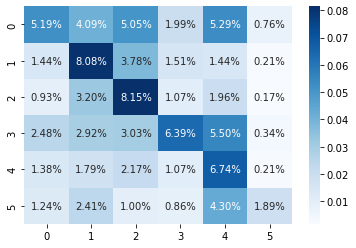

In [38]:
conf4 = confusion_matrix(new_states_np, Corrected_Pred4)
sns.heatmap(conf4/np.sum(conf4), annot=True, fmt='.2%', cmap='Blues')
plt.show()

In [44]:
model5 = keras.Sequential()
model5.add(layers.LSTM(24,  input_shape=(1,48), activation = 'relu', return_sequences = True))
model5.add(layers.LSTM(12))
model5.add(layers.Dense(6, activation='softmax'))

opt = keras.optimizers.Adam(learning_rate=0.005)
model5.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['mse'])
model5.summary()

history = model5.fit(Sub2_AllBand, Fingers_Subject2_OneHot, batch_size = 3, epochs=10, validation_split=0.2)

predictions5 = model5.predict(Sub2_AllBand)
print("Predicted values are: ", predictions5)
np.savetxt('DownsampledModel5_NorPred.txt',predictions5)
Corrected_Pred5 = numpy.argmax(predictions5, axis = 1)
print(Corrected_Pred5)
np.savetxt('DownsampledModel5_Pred.txt',Corrected_Pred5)

Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_18 (LSTM)               (None, 1, 24)             7008      
_________________________________________________________________
lstm_19 (LSTM)               (None, 12)                1776      
_________________________________________________________________
dense_17 (Dense)             (None, 6)                 78        
Total params: 8,862
Trainable params: 8,862
Non-trainable params: 0
_________________________________________________________________
Train on 2327 samples, validate on 582 samples
Epoch 1/10


2022-07-05 08:03:56.616997: W tensorflow/core/grappler/optimizers/implementation_selector.cc:310] Skipping optimization due to error while loading function libraries: Invalid argument: Functions '__inference___backward_standard_lstm_408938_409423' and '__inference___backward_standard_lstm_408938_409423_specialized_for_StatefulPartitionedCall_at___inference_distributed_function_409976' both implement 'lstm_69f58b31-0802-4f71-a9bb-63332989e594' but their signatures do not match.


2313/2327 [============================>.] - ETA: 0s - loss: 1.7710 - mse: 0.1377

2022-07-05 08:04:13.972095: W tensorflow/core/grappler/optimizers/implementation_selector.cc:310] Skipping optimization due to error while loading function libraries: Invalid argument: Functions '__inference_standard_lstm_412662' and '__inference_standard_lstm_412662_specialized_for_sequential_14_lstm_19_StatefulPartitionedCall_at___inference_distributed_function_413035' both implement 'lstm_e6c8cda8-370d-45ba-8212-93e934497a01' but their signatures do not match.


2327/2327 [==============================] - 23s 10ms/sample - loss: 1.7716 - mse: 0.1378 - val_loss: 1.7341 - val_mse: 0.1356
Epoch 2/10
2327/2327 [==============================] - 12s 5ms/sample - loss: 1.7483 - mse: 0.1363 - val_loss: 1.7434 - val_mse: 0.1367
Epoch 3/10
2327/2327 [==============================] - 9s 4ms/sample - loss: 1.7015 - mse: 0.1339 - val_loss: 1.7403 - val_mse: 0.1358
Epoch 4/10
2327/2327 [==============================] - 12s 5ms/sample - loss: 1.6384 - mse: 0.1307 - val_loss: 1.8339 - val_mse: 0.1412
Epoch 5/10
2327/2327 [==============================] - 11s 5ms/sample - loss: 1.5916 - mse: 0.1285 - val_loss: 1.7765 - val_mse: 0.1377
Epoch 6/10
2327/2327 [==============================] - 10s 4ms/sample - loss: 1.5646 - mse: 0.1269 - val_loss: 1.8676 - val_mse: 0.1383
Epoch 7/10
2327/2327 [==============================] - 18s 8ms/sample - loss: 1.5475 - mse: 0.1259 - val_loss: 1.8381 - val_mse: 0.1388
Epoch 8/10
2327/2327 [==============================

2022-07-05 08:06:12.298890: W tensorflow/core/grappler/optimizers/implementation_selector.cc:310] Skipping optimization due to error while loading function libraries: Invalid argument: Functions '__inference_cudnn_lstm_with_fallback_440383' and '__inference_standard_lstm_440272_specialized_for_sequential_14_lstm_19_StatefulPartitionedCall_at___inference_distributed_function_440575' both implement 'lstm_68340c7e-9c1e-4674-95df-3279285ebf9e' but their signatures do not match.


Predicted values are:  [[0.2319021  0.22549509 0.061802   0.16799791 0.10749516 0.20530768]
 [0.23610348 0.13144894 0.07056943 0.22042772 0.1587014  0.182749  ]
 [0.1986849  0.09143502 0.10649186 0.12418785 0.17543265 0.3037677 ]
 ...
 [0.37139237 0.12729868 0.18299378 0.26694235 0.04938282 0.00199002]
 [0.22858185 0.2079186  0.09099625 0.14255528 0.12361758 0.20633045]
 [0.20343116 0.01436817 0.06274449 0.47217676 0.23300691 0.01427246]]
[0 0 5 ... 0 0 3]


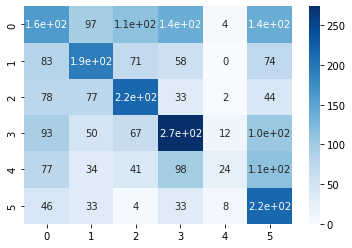

In [58]:
conf5 = confusion_matrix(new_states_np, Corrected_Pred5)
sns.heatmap(conf5, annot=True, cmap='Blues')

plt.show()

In [59]:
np.random.seed(0)

In [71]:
model6 = keras.Sequential()
model6.add(layers.LSTM(24,  input_shape=(1,48), activation = 'relu', return_sequences = True))
model6.add(layers.LSTM(12, activation = 'relu', return_sequences = True))
model6.add(layers.LSTM(6, activation = 'relu'))
model6.add(layers.Dense(6, activation='softmax'))

opt = keras.optimizers.Adam(learning_rate=0.005)
model6.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['mse'])
model6.summary()

history = model6.fit(Sub2_AllBand, Fingers_Subject2_OneHot, batch_size = 3, epochs=10, validation_split=0.2)

predictions6 = model6.predict(Sub2_AllBand)
print("Predicted values are: ", predictions6)
np.savetxt('DownsampledModel6_NorPred.txt',predictions6)
Corrected_Pred6 = numpy.argmax(predictions6, axis = 1)
print(Corrected_Pred6)
np.savetxt('DownsampledModel6_Pred.txt',Corrected_Pred6)

Model: "sequential_22"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_41 (LSTM)               (None, 1, 24)             7008      
_________________________________________________________________
lstm_42 (LSTM)               (None, 1, 12)             1776      
_________________________________________________________________
lstm_43 (LSTM)               (None, 6)                 456       
_________________________________________________________________
dense_25 (Dense)             (None, 6)                 42        
Total params: 9,282
Trainable params: 9,282
Non-trainable params: 0
_________________________________________________________________
Train on 2327 samples, validate on 582 samples
Epoch 1/10
2327/2327 [==============================] - 15s 7ms/sample - loss: 1.7767 - mse: 0.1380 - val_loss: 1.7532 - val_mse: 0.1367
Epoch 2/10
2327/2327 [==============================] - 10s 4ms/s

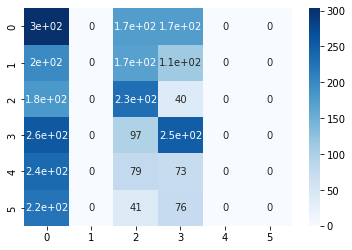

In [72]:
conf6 = confusion_matrix(new_states_np, Corrected_Pred6)
sns.heatmap(conf6, annot=True, cmap='Blues')

plt.show()

In [73]:
model7 = keras.Sequential()
model7.add(layers.LSTM(22,  input_shape=(1,48), activation = 'relu', return_sequences = True))
model7.add(layers.LSTM(10,activation = 'relu', return_sequences = True))
model7.add(layers.LSTM(8, activation = 'relu'))
model7.add(layers.Dense(6, activation='softmax'))

opt = keras.optimizers.Adam(learning_rate=0.005)
model7.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['mae','mse'])
model7.summary()

history = model7.fit(Sub2_AllBand, Fingers_Subject2_OneHot, batch_size = 3, epochs=10)

predictions7 = model7.predict(Sub2_AllBand)
print("Predicted values are: ", predictions7)
np.savetxt('DownsampledModel7_NorPred.txt',predictions7)
Corrected_Pred7 = numpy.argmax(predictions7, axis = 1)
print(Corrected_Pred7)
np.savetxt('DownsampledModel7_Pred.txt',Corrected_Pred7)

from sklearn.metrics import accuracy_score
print(accuracy_score(new_states_np, Corrected_Pred7))

Model: "sequential_23"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_44 (LSTM)               (None, 1, 22)             6248      
_________________________________________________________________
lstm_45 (LSTM)               (None, 1, 10)             1320      
_________________________________________________________________
lstm_46 (LSTM)               (None, 8)                 608       
_________________________________________________________________
dense_26 (Dense)             (None, 6)                 54        
Total params: 8,230
Trainable params: 8,230
Non-trainable params: 0
_________________________________________________________________
Train on 2909 samples
Epoch 1/10
2909/2909 [==============================] - 27s 9ms/sample - loss: 1.7717 - mae: 0.2757 - mse: 0.1378
Epoch 2/10
2909/2909 [==============================] - 23s 8ms/sample - loss: 1.7679 - mae: 0.2751 - mse: 0.1376

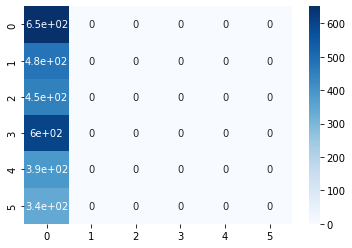

In [74]:
conf7 = confusion_matrix(new_states_np, Corrected_Pred7)
sns.heatmap(conf7, annot=True, cmap='Blues')

plt.show()

In [83]:
Sub2_AllBand = Sub2_AllBand.reshape(2909,48)

In [84]:
model8 = keras.Sequential()
model8.add(layers.Dense(48, input_dim=48, activation='relu'))
model8.add(layers.Reshape(( 1, 48)))
model8.add(layers.LSTM(22, activation = 'relu', return_sequences = True))
model8.add(layers.LSTM(10, activation = 'relu', return_sequences = True))
model8.add(layers.LSTM(8, activation = 'relu'))
model8.add(layers.Dense(6, activation='softmax'))

opt = keras.optimizers.Adam(learning_rate=0.005)
model8.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['mae','mse'])
model8.summary()

history = model8.fit(Sub2_AllBand, Fingers_Subject2_OneHot, batch_size = 3, epochs=10)

predictions8 = model8.predict(Sub2_AllBand)
print("Predicted values are: ", predictions8)
np.savetxt('DownsampledModel8_NorPred.txt',predictions8)
Corrected_Pred8 = numpy.argmax(predictions8, axis = 1)
print(Corrected_Pred8)
np.savetxt('DownsampledModel8_Pred.txt',Corrected_Pred8)

from sklearn.metrics import accuracy_score
print(accuracy_score(new_states_np, Corrected_Pred8))

Model: "sequential_31"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_37 (Dense)             (None, 48)                2352      
_________________________________________________________________
reshape_5 (Reshape)          (None, 1, 48)             0         
_________________________________________________________________
lstm_54 (LSTM)               (None, 1, 22)             6248      
_________________________________________________________________
lstm_55 (LSTM)               (None, 1, 10)             1320      
_________________________________________________________________
lstm_56 (LSTM)               (None, 8)                 608       
_________________________________________________________________
dense_38 (Dense)             (None, 6)                 54        
Total params: 10,582
Trainable params: 10,582
Non-trainable params: 0
_________________________________________________

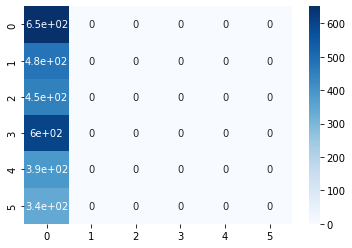

In [85]:
conf8 = confusion_matrix(new_states_np, Corrected_Pred8)
sns.heatmap(conf8, annot=True, cmap='Blues')

plt.show()

In [105]:
model9 = keras.Sequential()
model9.add(layers.Dense(48, input_dim=48, activation='relu'))
model9.add(layers.Reshape(( 1, 48)))
model9.add(layers.LSTM(24, activation = 'relu'))
model9.add(layers.Dense(6, activation='softmax'))

opt = keras.optimizers.Adam(learning_rate=0.005)
model9.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['mae','mse'])
model9.summary()

history = model9.fit(Sub2_AllBand, Fingers_Subject2_OneHot, batch_size = 1, epochs=10)

predictions9 = model9.predict(Sub2_AllBand)
print("Predicted values are: ", predictions9)
np.savetxt('DownsampledModel9_NorPred.txt',predictions9)
Corrected_Pred9 = numpy.argmax(predictions9, axis = 1)
print(Corrected_Pred9)
np.savetxt('DownsampledModel9_Pred.txt',Corrected_Pred9)

from sklearn.metrics import accuracy_score
print(accuracy_score(new_states_np, Corrected_Pred9))

Model: "sequential_43"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_68 (Dense)             (None, 48)                2352      
_________________________________________________________________
reshape_17 (Reshape)         (None, 1, 48)             0         
_________________________________________________________________
lstm_72 (LSTM)               (None, 24)                7008      
_________________________________________________________________
dense_69 (Dense)             (None, 6)                 150       
Total params: 9,510
Trainable params: 9,510
Non-trainable params: 0
_________________________________________________________________
Train on 2909 samples
Epoch 1/10
2909/2909 [==============================] - 45s 15ms/sample - loss: 1.7619 - mae: 0.2739 - mse: 0.1371
Epoch 2/10
2909/2909 [==============================] - 51s 17ms/sample - loss: 1.7262 - mae: 0.2698 - mse: 0.13

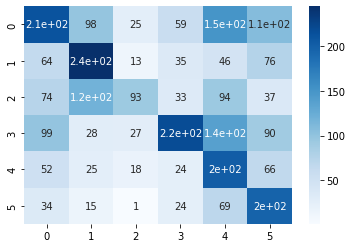

In [106]:
conf9 = confusion_matrix(new_states_np, Corrected_Pred9)
sns.heatmap(conf9, annot=True, cmap='Blues')

plt.show()

In [90]:
model10 = keras.Sequential()
model10.add(layers.Dense(48, input_dim=48, activation='relu'))
model10.add(layers.Dense(48, activation='relu'))
model10.add(layers.Reshape((1, 48)))
model10.add(layers.LSTM(24, activation = 'relu'))
model10.add(layers.Dense(6, activation='softmax'))

opt = keras.optimizers.Adam(learning_rate=0.005)
model10.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['mae','mse'])
model10.summary()

history = model10.fit(Sub2_AllBand, Fingers_Subject2_OneHot, batch_size = 1, epochs=10)

predictions10 = model10.predict(Sub2_AllBand)
print("Predicted values are: ", predictions10)
np.savetxt('DownsampledModel10_NorPred.txt',predictions10)
Corrected_Pred10 = numpy.argmax(predictions10, axis = 1)
print(Corrected_Pred10)
np.savetxt('DownsampledModel10_Pred.txt',Corrected_Pred10)

from sklearn.metrics import accuracy_score
print(accuracy_score(new_states_np, Corrected_Pred9))

Model: "sequential_35"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_47 (Dense)             (None, 48)                2352      
_________________________________________________________________
dense_48 (Dense)             (None, 48)                2352      
_________________________________________________________________
reshape_9 (Reshape)          (None, 1, 48)             0         
_________________________________________________________________
lstm_60 (LSTM)               (None, 24)                7008      
_________________________________________________________________
dense_49 (Dense)             (None, 6)                 150       
Total params: 11,862
Trainable params: 11,862
Non-trainable params: 0
_________________________________________________________________
Train on 2909 samples
Epoch 1/10
2909/2909 [==============================] - 25s 9ms/sample - loss: 1.7702 - mae: 

In [91]:
from sklearn.metrics import accuracy_score
print(accuracy_score(new_states_np, Corrected_Pred10))

0.301821931935373


In [92]:
model11 = keras.Sequential()
model11.add(layers.Dense(48, input_dim=48, activation='relu'))
model11.add(layers.Dense(48, activation='relu'))
model11.add(layers.Reshape((1, 48)))
model11.add(layers.LSTM(24, activation = 'relu', return_sequences=True))
model11.add(layers.LSTM(24, activation = 'relu'))
model11.add(layers.Dense(6, activation='softmax'))

opt = keras.optimizers.Adam(learning_rate=0.005)
model11.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['mae','mse'])
model11.summary()

history = model11.fit(Sub2_AllBand, Fingers_Subject2_OneHot, batch_size = 1, epochs=10)

predictions11 = model11.predict(Sub2_AllBand)
print("Predicted values are: ", predictions11)
np.savetxt('DownsampledModel11_NorPred.txt',predictions11)
Corrected_Pred11 = numpy.argmax(predictions11, axis = 1)
print(Corrected_Pred11)
np.savetxt('DownsampledModel11_Pred.txt',Corrected_Pred11)

from sklearn.metrics import accuracy_score
print(accuracy_score(new_states_np, Corrected_Pred11))

Model: "sequential_36"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_50 (Dense)             (None, 48)                2352      
_________________________________________________________________
dense_51 (Dense)             (None, 48)                2352      
_________________________________________________________________
reshape_10 (Reshape)         (None, 1, 48)             0         
_________________________________________________________________
lstm_61 (LSTM)               (None, 1, 24)             7008      
_________________________________________________________________
lstm_62 (LSTM)               (None, 24)                4704      
_________________________________________________________________
dense_52 (Dense)             (None, 6)                 150       
Total params: 16,566
Trainable params: 16,566
Non-trainable params: 0
_________________________________________________

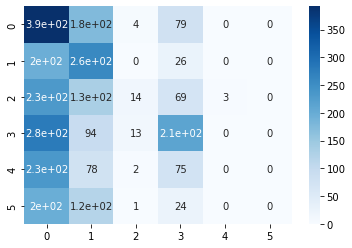

In [93]:
conf10 = confusion_matrix(new_states_np, Corrected_Pred10)
sns.heatmap(conf10, annot=True, cmap='Blues')

plt.show()

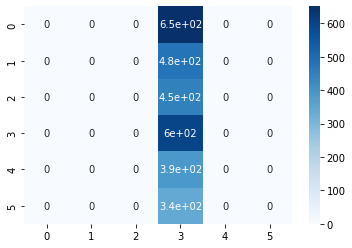

In [94]:
conf11 = confusion_matrix(new_states_np, Corrected_Pred11)
sns.heatmap(conf11, annot=True, cmap='Blues')

plt.show()

In [96]:
model12 = keras.Sequential()
model12.add(layers.Dense(24, input_dim=48, activation='relu'))
model12.add(layers.Dense(24, activation='relu'))
model12.add(layers.Reshape((1, 24)))
model12.add(layers.LSTM(12, activation = 'relu', return_sequences=True))
model12.add(layers.LSTM(12, activation = 'relu'))
model12.add(layers.Dense(6, activation='softmax'))

opt = keras.optimizers.Adam(learning_rate=0.005)
model12.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['mae','mse'])
model12.summary()

history = model12.fit(Sub2_AllBand, Fingers_Subject2_OneHot, batch_size = 1, epochs=10)

predictions12 = model12.predict(Sub2_AllBand)
print("Predicted values are: ", predictions12)
np.savetxt('DownsampledModel12_NorPred.txt',predictions12)
Corrected_Pred12 = numpy.argmax(predictions12, axis = 1)
print(Corrected_Pred12)
np.savetxt('DownsampledModel12_Pred.txt',Corrected_Pred12)

from sklearn.metrics import accuracy_score
print(accuracy_score(new_states_np, Corrected_Pred12))

Model: "sequential_38"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_56 (Dense)             (None, 24)                1176      
_________________________________________________________________
dense_57 (Dense)             (None, 24)                600       
_________________________________________________________________
reshape_12 (Reshape)         (None, 1, 24)             0         
_________________________________________________________________
lstm_65 (LSTM)               (None, 1, 12)             1776      
_________________________________________________________________
lstm_66 (LSTM)               (None, 12)                1200      
_________________________________________________________________
dense_58 (Dense)             (None, 6)                 78        
Total params: 4,830
Trainable params: 4,830
Non-trainable params: 0
___________________________________________________

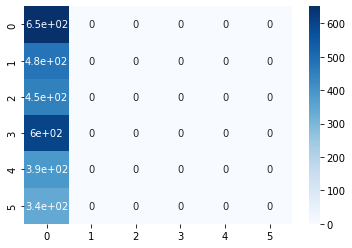

In [97]:
conf12 = confusion_matrix(new_states_np, Corrected_Pred12)
sns.heatmap(conf12, annot=True, cmap='Blues')

plt.show()

In [103]:
model13 = keras.Sequential()
model13.add(layers.Dense(24, input_dim=48, activation='relu'))
model13.add(layers.Reshape((1, 24)))
model13.add(layers.LSTM(12, activation = 'relu'))
model13.add(layers.Dense(6, activation='softmax'))

opt = keras.optimizers.Adam(learning_rate=0.005)
model13.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['mae','mse'])
model13.summary()

history = model13.fit(Sub2_AllBand, Fingers_Subject2_OneHot, batch_size = 1, epochs=10)

predictions13 = model12.predict(Sub2_AllBand)
print("Predicted values are: ", predictions13)
np.savetxt('DownsampledModel13_NorPred.txt',predictions13)
Corrected_Pred13 = numpy.argmax(predictions13, axis = 1)
print(Corrected_Pred13)
np.savetxt('DownsampledModel13_Pred.txt',Corrected_Pred13)

from sklearn.metrics import accuracy_score
print(accuracy_score(new_states_np, Corrected_Pred13))

Model: "sequential_42"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_66 (Dense)             (None, 24)                1176      
_________________________________________________________________
reshape_16 (Reshape)         (None, 1, 24)             0         
_________________________________________________________________
lstm_71 (LSTM)               (None, 12)                1776      
_________________________________________________________________
dense_67 (Dense)             (None, 6)                 78        
Total params: 3,030
Trainable params: 3,030
Non-trainable params: 0
_________________________________________________________________
Train on 2909 samples
Epoch 1/10
2909/2909 [==============================] - 54s 18ms/sample - loss: 1.7627 - mae: 0.2739 - mse: 0.1372
Epoch 2/10
2909/2909 [==============================] - 49s 17ms/sample - loss: 1.7382 - mae: 0.2716 - mse: 0.13

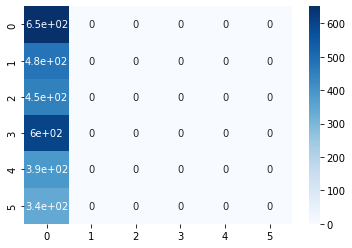

In [104]:
conf13 = confusion_matrix(new_states_np, Corrected_Pred13)
sns.heatmap(conf13, annot=True, cmap='Blues')

plt.show()

Now, I should try and incorporate some BiLSTM

In [43]:
Fingers_Subject2_OneHot =  Fingers_Subject2_OneHot.reshape(2909,1,6)

In [48]:
print(Sub2_AllBand)
print(Fingers_Subject2_OneHot)

[[[6.38219722e-05 5.31708016e-04 1.54263975e-02 ... 8.65034828e-04
   4.12390065e-05 1.45412127e-02]]

 [[1.04276522e-02 1.10372674e-02 1.13069675e-03 ... 3.33163743e-03
   1.36630534e-02 1.62473962e-03]]

 [[5.89806183e-04 4.72651872e-03 2.31055411e-03 ... 3.89885204e-03
   1.51630818e-03 1.01663790e-03]]

 ...

 [[6.71020130e-03 3.49129969e-03 1.83690376e-03 ... 2.25230769e-03
   1.06973154e-03 1.26477789e-03]]

 [[8.58947257e-03 9.16683231e-03 9.91706623e-04 ... 1.55148426e-02
   1.18042174e-03 4.46390827e-03]]

 [[2.57775348e-03 1.20029529e-03 1.03333415e-02 ... 6.52744517e-03
   2.66149590e-03 2.05360553e-03]]]
[[[1. 0. 0. 0. 0. 0.]]

 [[1. 0. 0. 0. 0. 0.]]

 [[1. 0. 0. 0. 0. 0.]]

 ...

 [[1. 0. 0. 0. 0. 0.]]

 [[1. 0. 0. 0. 0. 0.]]

 [[1. 0. 0. 0. 0. 0.]]]


In [64]:
import tensorflow 
from tensorflow import keras
from tensorflow.keras.layers import LSTM, Dense, Bidirectional, Reshape
from tensorflow.keras.regularizers import l2
import numpy

model_Bi = keras.Sequential()
forward_layer = LSTM(12, return_sequences=True, activation='relu')
backward_layer = LSTM(12, activation='relu', return_sequences=True, go_backwards=True)
model_Bi.add(Bidirectional(forward_layer, backward_layer=backward_layer, input_shape=(1,48)))
# model_Bi.add(Bidirectional(LSTM(10, activation="relu", return_sequences=True)))
model_Bi.add(Dense(6, activation='softmax'))

opt = keras.optimizers.Adam(learning_rate=0.005)
model_Bi.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['mae','mse'])
model_Bi.summary()

history = model_Bi.fit(Sub2_AllBand, Fingers_Subject2_OneHot, batch_size = 1, epochs=10)

predictions_Bi = model_Bi.predict(Sub2_AllBand)

Model: "sequential_30"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_31 (Bidirectio (None, 1, 24)             5856      
_________________________________________________________________
dense_17 (Dense)             (None, 1, 6)              150       
Total params: 6,006
Trainable params: 6,006
Non-trainable params: 0
_________________________________________________________________
Train on 2909 samples
Epoch 1/10
2909/2909 [==============================] - 25s 9ms/sample - loss: 1.7509 - mae: 0.2731 - mse: 0.1366
Epoch 2/10
2909/2909 [==============================] - 21s 7ms/sample - loss: 1.6638 - mae: 0.2651 - mse: 0.1319
Epoch 3/10
2909/2909 [==============================] - 19s 7ms/sample - loss: 1.5961 - mae: 0.2575 - mse: 0.1282
Epoch 4/10
2909/2909 [==============================] - 20s 7ms/sample - loss: 1.5460 - mae: 0.2520 - mse: 0.1255
Epoch 5/10
2909/2909 [=============

In [65]:
print(predictions_Bi.shape)
predictions_Bi = predictions_Bi.reshape(2909,6)

Corrected_Pred_Bi = numpy.argmax(predictions_Bi, axis = 1)
print(Corrected_Pred_Bi)

from sklearn.metrics import accuracy_score
print(accuracy_score(new_states_np, Corrected_Pred_Bi))


(2909, 1, 6)
[2 0 4 ... 2 2 1]
0.41457545548298386


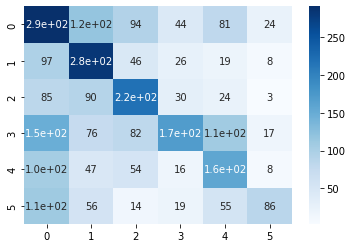

In [66]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

conf_Bi = confusion_matrix(new_states_np, Corrected_Pred_Bi)
sns.heatmap(conf_Bi, annot=True, cmap='Blues')

plt.show()


In [70]:
import tensorflow 
from tensorflow import keras
from tensorflow.keras.layers import LSTM, Dense, Bidirectional, Reshape
from tensorflow.keras.regularizers import l2
import numpy

model_Bi2 = keras.Sequential()
forward_layer = LSTM(24, return_sequences=True, activation='relu')
backward_layer = LSTM(24, activation='relu', return_sequences=True, go_backwards=True)
model_Bi2.add(Bidirectional(forward_layer, backward_layer=backward_layer, input_shape=(1,48)))
model_Bi2.add(Dense(6, activation='softmax'))

opt = keras.optimizers.Adam(learning_rate=0.005)
model_Bi2.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['mae','mse'])
model_Bi2.summary()

history = model_Bi2.fit(Sub2_AllBand, Fingers_Subject2_OneHot, batch_size = 1, epochs=10)

predictions_Bi2 = model_Bi2.predict(Sub2_AllBand)

Model: "sequential_33"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_34 (Bidirectio (None, 1, 48)             14016     
_________________________________________________________________
dense_20 (Dense)             (None, 1, 6)              294       
Total params: 14,310
Trainable params: 14,310
Non-trainable params: 0
_________________________________________________________________
Train on 2909 samples
Epoch 1/10
2909/2909 [==============================] - 24s 8ms/sample - loss: 1.7480 - mae: 0.2729 - mse: 0.1364
Epoch 2/10
2909/2909 [==============================] - 20s 7ms/sample - loss: 1.6541 - mae: 0.2639 - mse: 0.1316
Epoch 3/10
2909/2909 [==============================] - 18s 6ms/sample - loss: 1.5809 - mae: 0.2561 - mse: 0.1278
Epoch 4/10
2909/2909 [==============================] - 19s 6ms/sample - loss: 1.5285 - mae: 0.2498 - mse: 0.1243
Epoch 5/10
2909/2909 [===========

In [71]:
Fingers_Subject2_OneHot =  Fingers_Subject2_OneHot.reshape(2909,6)

In [75]:
import tensorflow 
from tensorflow import keras
from tensorflow.keras.layers import LSTM, Dense, Bidirectional, Reshape
from tensorflow.keras.regularizers import l2
import numpy

model_Bi3 = keras.Sequential()
forward_layer = LSTM(24, return_sequences=True, activation='relu')
backward_layer = LSTM(24, activation='relu', return_sequences=True, go_backwards=True)
model_Bi3.add(Bidirectional(forward_layer, backward_layer=backward_layer, input_shape=(1,48)))
model_Bi3.add(LSTM(12, activation="relu"))
model_Bi3.add(Dense(6, activation='softmax'))

opt = keras.optimizers.Adam(learning_rate=0.005)
model_Bi3.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['mae','mse'])
model_Bi3.summary()

history = model_Bi3.fit(Sub2_AllBand, Fingers_Subject2_OneHot, batch_size = 1, epochs=10)

predictions_Bi3 = model_Bi3.predict(Sub2_AllBand)

Model: "sequential_35"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_36 (Bidirectio (None, 1, 48)             14016     
_________________________________________________________________
lstm_58 (LSTM)               (None, 12)                2928      
_________________________________________________________________
dense_22 (Dense)             (None, 6)                 78        
Total params: 17,022
Trainable params: 17,022
Non-trainable params: 0
_________________________________________________________________
Train on 2909 samples
Epoch 1/10
2909/2909 [==============================] - 25s 9ms/sample - loss: 1.7717 - mae: 0.2755 - mse: 0.1378
Epoch 2/10
2909/2909 [==============================] - 22s 7ms/sample - loss: 1.7698 - mae: 0.2750 - mse: 0.1377
Epoch 3/10
2909/2909 [==============================] - 25s 9ms/sample - loss: 1.7653 - mae: 0.2744 - mse: 0.1374
Epoch 4/10
2909

In [76]:
import tensorflow 
from tensorflow import keras
from tensorflow.keras.layers import LSTM, Dense, Bidirectional, Reshape
from tensorflow.keras.regularizers import l2
import numpy

model_Bi4 = keras.Sequential()
model_Bi4.add(LSTM(48, activation="relu", input_shape=(1,48), return_sequences=True))
forward_layer = LSTM(12, activation='relu')
backward_layer = LSTM(12, activation='relu', go_backwards=True)
model_Bi4.add(Bidirectional(forward_layer, backward_layer=backward_layer))
model_Bi4.add(Dense(6, activation='softmax'))

opt = keras.optimizers.Adam(learning_rate=0.005)
model_Bi4.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['mae','mse'])
model_Bi4.summary()

history = model_Bi4.fit(Sub2_AllBand, Fingers_Subject2_OneHot, batch_size = 1, epochs=10)

predictions_Bi4 = model_Bi4.predict(Sub2_AllBand)

Model: "sequential_36"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_59 (LSTM)               (None, 1, 48)             18624     
_________________________________________________________________
bidirectional_37 (Bidirectio (None, 24)                5856      
_________________________________________________________________
dense_23 (Dense)             (None, 6)                 150       
Total params: 24,630
Trainable params: 24,630
Non-trainable params: 0
_________________________________________________________________
Train on 2909 samples
Epoch 1/10
2909/2909 [==============================] - 26s 9ms/sample - loss: 1.7697 - mae: 0.2748 - mse: 0.1376
Epoch 2/10
2909/2909 [==============================] - 23s 8ms/sample - loss: 1.7438 - mae: 0.2721 - mse: 0.1363
Epoch 3/10
2909/2909 [==============================] - 26s 9ms/sample - loss: 1.6986 - mae: 0.2674 - mse: 0.1340
Epoch 4/10
2909

In [77]:
import tensorflow 
from tensorflow import keras
from tensorflow.keras.layers import LSTM, Dense, Bidirectional, Reshape
from tensorflow.keras.regularizers import l2
import numpy

model_Bi5 = keras.Sequential()
model_Bi5.add(LSTM(24, activation="relu", input_shape=(1,48), return_sequences=True))
forward_layer = LSTM(10, activation='relu')
backward_layer = LSTM(10, activation='relu', go_backwards=True)
model_Bi5.add(Bidirectional(forward_layer, backward_layer=backward_layer))
model_Bi5.add(Dense(6, activation='softmax'))

opt = keras.optimizers.Adam(learning_rate=0.005)
model_Bi5.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['mae','mse'])
model_Bi5.summary()

history = model_Bi5.fit(Sub2_AllBand, Fingers_Subject2_OneHot, batch_size = 1, epochs=10)

predictions_Bi5 = model_Bi5.predict(Sub2_AllBand)

Model: "sequential_37"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_62 (LSTM)               (None, 1, 24)             7008      
_________________________________________________________________
bidirectional_38 (Bidirectio (None, 20)                2800      
_________________________________________________________________
dense_24 (Dense)             (None, 6)                 126       
Total params: 9,934
Trainable params: 9,934
Non-trainable params: 0
_________________________________________________________________
Train on 2909 samples
Epoch 1/10
2909/2909 [==============================] - 24s 8ms/sample - loss: 1.7675 - mae: 0.2746 - mse: 0.1375
Epoch 2/10
2909/2909 [==============================] - 20s 7ms/sample - loss: 1.7544 - mae: 0.2733 - mse: 0.1368
Epoch 3/10
2909/2909 [==============================] - 20s 7ms/sample - loss: 1.7442 - mae: 0.2721 - mse: 0.1363
Epoch 4/10
2909/2

In [78]:
import tensorflow 
from tensorflow import keras
from tensorflow.keras.layers import LSTM, Dense, Bidirectional, Reshape
from tensorflow.keras.regularizers import l2
import numpy

model_Bi6 = keras.Sequential()
model_Bi6.add(LSTM(12, activation="relu", input_shape=(1,48), return_sequences=True))
forward_layer = LSTM(5, activation='relu')
backward_layer = LSTM(5, activation='relu', go_backwards=True)
model_Bi6.add(Bidirectional(forward_layer, backward_layer=backward_layer))
model_Bi6.add(Dense(6, activation='softmax'))

opt = keras.optimizers.Adam(learning_rate=0.005)
model_Bi6.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['mae','mse'])
model_Bi6.summary()

history = model_Bi6.fit(Sub2_AllBand, Fingers_Subject2_OneHot, batch_size = 1, epochs=10)

predictions_Bi6 = model_Bi6.predict(Sub2_AllBand)

Model: "sequential_38"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_65 (LSTM)               (None, 1, 12)             2928      
_________________________________________________________________
bidirectional_39 (Bidirectio (None, 10)                720       
_________________________________________________________________
dense_25 (Dense)             (None, 6)                 66        
Total params: 3,714
Trainable params: 3,714
Non-trainable params: 0
_________________________________________________________________
Train on 2909 samples
Epoch 1/10
2909/2909 [==============================] - 24s 8ms/sample - loss: 1.7693 - mae: 0.2748 - mse: 0.1375
Epoch 2/10
2909/2909 [==============================] - 21s 7ms/sample - loss: 1.7526 - mae: 0.2728 - mse: 0.1367
Epoch 3/10
2909/2909 [==============================] - 25s 8ms/sample - loss: 1.7281 - mae: 0.2711 - mse: 0.1357
Epoch 4/10
2909/2

(2909, 1, 6)
[2 0 0 ... 0 0 1]
0.44929529047782746


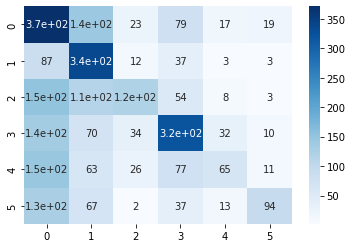

In [73]:
print(predictions_Bi2.shape)
predictions_Bi2 = predictions_Bi2.reshape(2909,6)

Corrected_Pred_Bi2 = numpy.argmax(predictions_Bi2, axis = 1)
print(Corrected_Pred_Bi2)

from sklearn.metrics import accuracy_score
print(accuracy_score(new_states_np, Corrected_Pred_Bi2))

conf_Bi2 = confusion_matrix(new_states_np, Corrected_Pred_Bi2)
sns.heatmap(conf_Bi2, annot=True, cmap='Blues')

plt.show()


(2909, 6)
[1 5 5 ... 0 1 1]
0.31041595049845305


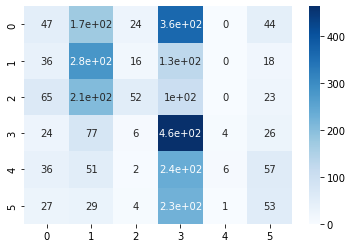

In [83]:
print(predictions_Bi3.shape)
predictions_Bi3 = predictions_Bi3.reshape(2909,6)

Corrected_Pred_Bi3 = numpy.argmax(predictions_Bi3, axis = 1)
print(Corrected_Pred_Bi3)

from sklearn.metrics import accuracy_score
print(accuracy_score(new_states_np, Corrected_Pred_Bi3))

conf_Bi3 = confusion_matrix(new_states_np, Corrected_Pred_Bi3)
sns.heatmap(conf_Bi3, annot=True, cmap='Blues')

plt.show()

(2909, 6)
[1 5 4 ... 2 1 1]
0.377793056033001


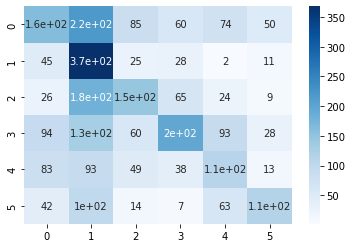

In [79]:
print(predictions_Bi4.shape)
predictions_Bi4 = predictions_Bi4.reshape(2909,6)

Corrected_Pred_Bi4 = numpy.argmax(predictions_Bi4, axis = 1)
print(Corrected_Pred_Bi4)

from sklearn.metrics import accuracy_score
print(accuracy_score(new_states_np, Corrected_Pred_Bi4))

conf_Bi4 = confusion_matrix(new_states_np, Corrected_Pred_Bi4)
sns.heatmap(conf_Bi4, annot=True, cmap='Blues')

plt.show()

(2909, 6)
[1 0 4 ... 2 1 1]
0.36988655895496736


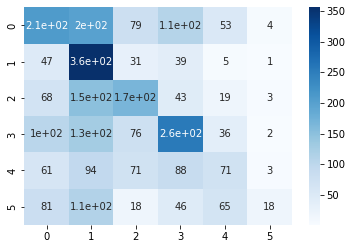

In [80]:
print(predictions_Bi5.shape)
predictions_Bi5 = predictions_Bi5.reshape(2909,6)

Corrected_Pred_Bi5 = numpy.argmax(predictions_Bi5, axis = 1)
print(Corrected_Pred_Bi5)

from sklearn.metrics import accuracy_score
print(accuracy_score(new_states_np, Corrected_Pred_Bi5))

conf_Bi5 = confusion_matrix(new_states_np, Corrected_Pred_Bi5)
sns.heatmap(conf_Bi5, annot=True, cmap='Blues')

plt.show()

(2909, 6)
[2 5 4 ... 2 1 0]
0.3269164661395669


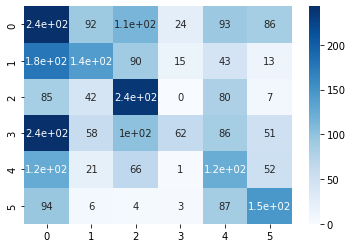

In [81]:
print(predictions_Bi6.shape)
predictions_Bi6 = predictions_Bi6.reshape(2909,6)

Corrected_Pred_Bi6 = numpy.argmax(predictions_Bi6, axis = 1)
print(Corrected_Pred_Bi6)

from sklearn.metrics import accuracy_score
print(accuracy_score(new_states_np, Corrected_Pred_Bi6))

conf_Bi6 = confusion_matrix(new_states_np, Corrected_Pred_Bi6)
sns.heatmap(conf_Bi6, annot=True, cmap='Blues')

plt.show()

In [85]:
import tensorflow 
from tensorflow import keras
from tensorflow.keras.layers import LSTM, Dense, Bidirectional, Reshape
from tensorflow.keras.regularizers import l2
import numpy


# B4  Updated
model_Bi7 = keras.Sequential()
model_Bi7.add(LSTM(48, activation="relu", input_shape=(1,48), return_sequences=True))
forward_layer = LSTM(12, activation='relu')
backward_layer = LSTM(12, activation='relu', go_backwards=True)
model_Bi7.add(Bidirectional(forward_layer, backward_layer=backward_layer))
model_Bi7.add(Dense(12, activation='relu'))
model_Bi7.add(Dense(6, activation='softmax'))

opt = keras.optimizers.Adam(learning_rate=0.005)
model_Bi7.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['mae','mse'])
model_Bi7.summary()

history = model_Bi7.fit(Sub2_AllBand, Fingers_Subject2_OneHot, batch_size = 1, epochs=10)

predictions_Bi7 = model_Bi7.predict(Sub2_AllBand)


Model: "sequential_40"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_71 (LSTM)               (None, 1, 48)             18624     
_________________________________________________________________
bidirectional_41 (Bidirectio (None, 24)                5856      
_________________________________________________________________
dense_28 (Dense)             (None, 12)                300       
_________________________________________________________________
dense_29 (Dense)             (None, 6)                 78        
Total params: 24,858
Trainable params: 24,858
Non-trainable params: 0
_________________________________________________________________
Train on 2909 samples
Epoch 1/10
2909/2909 [==============================] - 31s 11ms/sample - loss: 1.7718 - mae: 0.2753 - mse: 0.1378
Epoch 2/10
2909/2909 [==============================] - 25s 9ms/sample - loss: 1.7681 - mae: 0.2750 - mse: 0.1

In [86]:
import tensorflow 
from tensorflow import keras
from tensorflow.keras.layers import LSTM, Dense, Bidirectional, Reshape
from tensorflow.keras.regularizers import l2
import numpy

# B2 Updated

model_Bi8 = keras.Sequential()
forward_layer = LSTM(24, activation='relu')
backward_layer = LSTM(24, activation='relu',go_backwards=True)
model_Bi8.add(Bidirectional(forward_layer, backward_layer=backward_layer, input_shape=(1,48)))
model_Bi8.add(Dense(24, activation='relu'))
model_Bi8.add(Dense(6, activation='softmax'))

opt = keras.optimizers.Adam(learning_rate=0.005)
model_Bi8.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['mae','mse'])
model_Bi8.summary()

history = model_Bi8.fit(Sub2_AllBand, Fingers_Subject2_OneHot, batch_size = 1, epochs=10)

predictions_Bi8 = model_Bi8.predict(Sub2_AllBand)

Model: "sequential_41"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_42 (Bidirectio (None, 48)                14016     
_________________________________________________________________
dense_30 (Dense)             (None, 24)                1176      
_________________________________________________________________
dense_31 (Dense)             (None, 6)                 150       
Total params: 15,342
Trainable params: 15,342
Non-trainable params: 0
_________________________________________________________________
Train on 2909 samples
Epoch 1/10
2909/2909 [==============================] - 20s 7ms/sample - loss: 1.7662 - mae: 0.2744 - mse: 0.1375
Epoch 2/10
2909/2909 [==============================] - 17s 6ms/sample - loss: 1.7510 - mae: 0.2727 - mse: 0.1366
Epoch 3/10
2909/2909 [==============================] - 17s 6ms/sample - loss: 1.7345 - mae: 0.2714 - mse: 0.1359
Epoch 4/10
2909

In [87]:
import tensorflow 
from tensorflow import keras
from tensorflow.keras.layers import LSTM, Dense, Bidirectional, Reshape
from tensorflow.keras.regularizers import l2
import numpy

# B2 Updated

model_Bi9 = keras.Sequential()
forward_layer = LSTM(24, activation='relu')
backward_layer = LSTM(24, activation='relu',go_backwards=True)
model_Bi9.add(Bidirectional(forward_layer, backward_layer=backward_layer, input_shape=(1,48)))
model_Bi9.add(Dense(24, activation='relu'))
model_Bi9.add(Dense(12, activation='relu'))
model_Bi9.add(Dense(6, activation='softmax'))

opt = keras.optimizers.Adam(learning_rate=0.005)
model_Bi9.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['mae','mse'])
model_Bi9.summary()

history = model_Bi9.fit(Sub2_AllBand, Fingers_Subject2_OneHot, batch_size = 1, epochs=10)

predictions_Bi9 = model_Bi9.predict(Sub2_AllBand)

Model: "sequential_42"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_43 (Bidirectio (None, 48)                14016     
_________________________________________________________________
dense_32 (Dense)             (None, 24)                1176      
_________________________________________________________________
dense_33 (Dense)             (None, 12)                300       
_________________________________________________________________
dense_34 (Dense)             (None, 6)                 78        
Total params: 15,570
Trainable params: 15,570
Non-trainable params: 0
_________________________________________________________________
Train on 2909 samples
Epoch 1/10
2909/2909 [==============================] - 22s 8ms/sample - loss: 1.7709 - mae: 0.2749 - mse: 0.1377
Epoch 2/10
2909/2909 [==============================] - 35s 12ms/sample - loss: 1.7578 - mae: 0.2732 - mse: 0.1

In [88]:
import tensorflow 
from tensorflow import keras
from tensorflow.keras.layers import LSTM, Dense, Bidirectional, Reshape
from tensorflow.keras.regularizers import l2
import numpy

# B2 Updated

model_Bi10 = keras.Sequential()
forward_layer = LSTM(24, activation='relu')
backward_layer = LSTM(24, activation='relu',go_backwards=True)
model_Bi10.add(Bidirectional(forward_layer, backward_layer=backward_layer, input_shape=(1,48)))
model_Bi10.add(Dense(12, activation='relu'))
model_Bi10.add(Dense(6, activation='softmax'))

opt = keras.optimizers.Adam(learning_rate=0.005)
model_Bi10.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['mae','mse'])
model_Bi10.summary()

history = model_Bi10.fit(Sub2_AllBand, Fingers_Subject2_OneHot, batch_size = 1, epochs=10)

predictions_Bi10 = model_Bi10.predict(Sub2_AllBand)

Model: "sequential_43"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_44 (Bidirectio (None, 48)                14016     
_________________________________________________________________
dense_35 (Dense)             (None, 12)                588       
_________________________________________________________________
dense_36 (Dense)             (None, 6)                 78        
Total params: 14,682
Trainable params: 14,682
Non-trainable params: 0
_________________________________________________________________
Train on 2909 samples
Epoch 1/10
2909/2909 [==============================] - 20s 7ms/sample - loss: 1.7649 - mae: 0.2745 - mse: 0.1374
Epoch 2/10
2909/2909 [==============================] - 18s 6ms/sample - loss: 1.7510 - mae: 0.2725 - mse: 0.1366
Epoch 3/10
2909/2909 [==============================] - 20s 7ms/sample - loss: 1.7454 - mae: 0.2722 - mse: 0.1363
Epoch 4/10
2909

(2909, 6)
[0 0 0 ... 0 0 0]
0.2237882433826057


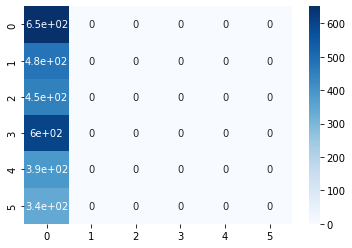

In [89]:
print(predictions_Bi7.shape)
predictions_Bi7 = predictions_Bi7.reshape(2909,6)

Corrected_Pred_Bi7 = numpy.argmax(predictions_Bi7, axis = 1)
print(Corrected_Pred_Bi7)

from sklearn.metrics import accuracy_score
print(accuracy_score(new_states_np, Corrected_Pred_Bi7))

conf_Bi7 = confusion_matrix(new_states_np, Corrected_Pred_Bi7)
sns.heatmap(conf_Bi7, annot=True, cmap='Blues')

plt.show()

(2909, 6)
[2 0 3 ... 2 1 1]
0.34410450326572706


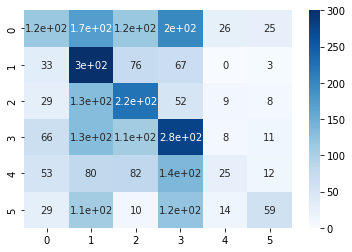

In [90]:
print(predictions_Bi8.shape)
predictions_Bi8 = predictions_Bi8.reshape(2909,6)

Corrected_Pred_Bi8 = numpy.argmax(predictions_Bi8, axis = 1)
print(Corrected_Pred_Bi8)

from sklearn.metrics import accuracy_score
print(accuracy_score(new_states_np, Corrected_Pred_Bi8))

conf_Bi8 = confusion_matrix(new_states_np, Corrected_Pred_Bi8)
sns.heatmap(conf_Bi8, annot=True, cmap='Blues')

plt.show()

(2909, 6)
[2 3 4 ... 2 2 2]
0.320385012031626


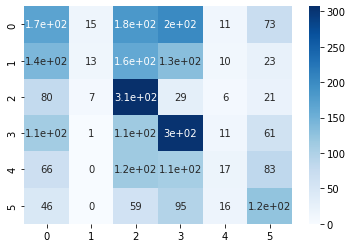

In [91]:
print(predictions_Bi9.shape)
predictions_Bi9 = predictions_Bi9.reshape(2909,6)

Corrected_Pred_Bi9 = numpy.argmax(predictions_Bi9, axis = 1)
print(Corrected_Pred_Bi9)

from sklearn.metrics import accuracy_score
print(accuracy_score(new_states_np, Corrected_Pred_Bi9))

conf_Bi9 = confusion_matrix(new_states_np, Corrected_Pred_Bi9)
sns.heatmap(conf_Bi9, annot=True, cmap='Blues')

plt.show()

(2909, 6)
[2 5 4 ... 2 1 0]
0.30663458233069785


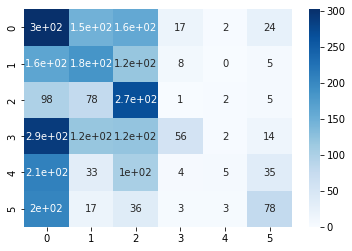

In [92]:
print(predictions_Bi10.shape)
predictions_Bi10 = predictions_Bi10.reshape(2909,6)

Corrected_Pred_Bi10 = numpy.argmax(predictions_Bi10, axis = 1)
print(Corrected_Pred_Bi6)

from sklearn.metrics import accuracy_score
print(accuracy_score(new_states_np, Corrected_Pred_Bi10))

conf_Bi10 = confusion_matrix(new_states_np, Corrected_Pred_Bi10)
sns.heatmap(conf_Bi10, annot=True, cmap='Blues')

plt.show()

In [96]:
import tensorflow 
from tensorflow import keras
from tensorflow.keras.layers import LSTM, Dense, Bidirectional, Reshape, Conv1D
from tensorflow.keras.regularizers import l2
import numpy

model_Bi11 = keras.Sequential()
model_Bi11.add(Conv1D(24, 1, activation='relu', input_shape=(1,48)))
forward_layer = LSTM(12, activation='relu')
backward_layer = LSTM(12, activation='relu', go_backwards=True)
model_Bi11.add(Bidirectional(forward_layer, backward_layer=backward_layer))
model_Bi11.add(Dense(6, activation='softmax'))

opt = keras.optimizers.Adam(learning_rate=0.005)
model_Bi11.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['mae','mse'])
model_Bi11.summary()

history = model_Bi11.fit(Sub2_AllBand, Fingers_Subject2_OneHot, batch_size = 1, epochs=20)

predictions_Bi11 = model_Bi11.predict(Sub2_AllBand)

Model: "sequential_47"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_3 (Conv1D)            (None, 1, 24)             1176      
_________________________________________________________________
bidirectional_47 (Bidirectio (None, 24)                3552      
_________________________________________________________________
dense_39 (Dense)             (None, 6)                 150       
Total params: 4,878
Trainable params: 4,878
Non-trainable params: 0
_________________________________________________________________
Train on 2909 samples
Epoch 1/20
2909/2909 [==============================] - 23s 8ms/sample - loss: 1.7671 - mae: 0.2745 - mse: 0.1376
Epoch 2/20
2909/2909 [==============================] - 21s 7ms/sample - loss: 1.7313 - mae: 0.2708 - mse: 0.1357
Epoch 3/20
2909/2909 [==============================] - 22s 7ms/sample - loss: 1.6792 - mae: 0.2658 - mse: 0.1331
Epoch 4/20
2909/2

In [118]:
import tensorflow 
from tensorflow import keras
from tensorflow.keras.layers import LSTM, Dense, Bidirectional, Reshape, Conv1D
from tensorflow.keras.regularizers import l2
import numpy

model_Bi12 = keras.Sequential()
model_Bi12.add(Conv1D(24, 1, activation='relu', input_shape=(1,48)))
forward_layer = LSTM(10, activation='relu')
backward_layer = LSTM(10, activation='relu', go_backwards=True)
model_Bi12.add(Bidirectional(forward_layer, backward_layer=backward_layer))
model_Bi12.add(Dense(12, activation='relu'))
model_Bi12.add(Dense(6, activation='softmax'))

opt = keras.optimizers.Adam(learning_rate=0.005)
model_Bi12.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['mae','mse'])
model_Bi12.summary()

history = model_Bi12.fit(Sub2_AllBand, Fingers_Subject2_OneHot, batch_size = 2, epochs=100)

predictions_Bi12 = model_Bi12.predict(Sub2_AllBand)

Model: "sequential_60"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_16 (Conv1D)           (None, 1, 24)             1176      
_________________________________________________________________
bidirectional_60 (Bidirectio (None, 20)                2800      
_________________________________________________________________
dense_58 (Dense)             (None, 12)                252       
_________________________________________________________________
dense_59 (Dense)             (None, 6)                 78        
Total params: 4,306
Trainable params: 4,306
Non-trainable params: 0
_________________________________________________________________
Train on 2909 samples
Epoch 1/100
   2/2909 [..............................] - ETA: 2:45:08

KeyboardInterrupt: 

In [124]:
import tensorflow 
from tensorflow import keras
from tensorflow.keras.layers import LSTM, Dense, Bidirectional, Reshape, Conv1D
from tensorflow.keras.regularizers import l2
import numpy

model_Bi13 = keras.Sequential()
model_Bi13.add(Conv1D(48, 1, activation='relu', input_shape=(1,48)))
model_Bi13.add(Conv1D(24, 1, activation='relu', ))
forward_layer = LSTM(10, activation='relu')
backward_layer = LSTM(10, activation='relu', go_backwards=True)
model_Bi13.add(Bidirectional(forward_layer, backward_layer=backward_layer))
# model_Bi13.add(Dense(12, activation='relu'))
model_Bi13.add(Dense(6, activation='softmax'))

opt = keras.optimizers.Adam(learning_rate=0.005)
model_Bi13.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['mae','mse'])
model_Bi13.summary()

history = model_Bi13.fit(Sub2_AllBand, Fingers_Subject2_OneHot, batch_size = 10, epochs=500)

predictions_Bi13 = model_Bi13.predict(Sub2_AllBand)

Model: "sequential_64"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_20 (Conv1D)           (None, 1, 48)             2352      
_________________________________________________________________
conv1d_21 (Conv1D)           (None, 1, 24)             1176      
_________________________________________________________________
bidirectional_64 (Bidirectio (None, 20)                2800      
_________________________________________________________________
dense_63 (Dense)             (None, 6)                 126       
Total params: 6,454
Trainable params: 6,454
Non-trainable params: 0
_________________________________________________________________
Train on 2909 samples
Epoch 1/500
2909/2909 [==============================] - 6s 2ms/sample - loss: 1.7658 - mae: 0.2747 - mse: 0.1375
Epoch 2/500
2909/2909 [==============================] - 2s 674us/sample - loss: 1.7483 - mae: 0.2731 - mse: 0.13

In [105]:
import tensorflow 
from tensorflow import keras
from tensorflow.keras.layers import LSTM, Dense, Bidirectional, Reshape, Conv1D
from tensorflow.keras.regularizers import l2
import numpy

model_Bi14 = keras.Sequential()
model_Bi14.add(Conv1D(24, 1, activation='relu', input_shape=(1,48)))
forward_layer = LSTM(10, activation='relu')
backward_layer = LSTM(10, activation='relu', go_backwards=True)
model_Bi14.add(Bidirectional(forward_layer, backward_layer=backward_layer))
# model_Bi14.add(Dense(12, activation='relu'))
model_Bi14.add(Dense(6, activation='softmax'))

opt = keras.optimizers.Adam(learning_rate=0.005)
model_Bi14.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['mae','mse'])
model_Bi14.summary()

history = model_Bi14.fit(Sub2_AllBand, Fingers_Subject2_OneHot, batch_size = 20, epochs=30)

predictions_Bi14 = model_Bi14.predict(Sub2_AllBand)

Model: "sequential_52"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_8 (Conv1D)            (None, 1, 24)             1176      
_________________________________________________________________
bidirectional_52 (Bidirectio (None, 20)                2800      
_________________________________________________________________
dense_48 (Dense)             (None, 6)                 126       
Total params: 4,102
Trainable params: 4,102
Non-trainable params: 0
_________________________________________________________________
Train on 2909 samples
Epoch 1/30
2909/2909 [==============================] - 5s 2ms/sample - loss: 1.7684 - mae: 0.2753 - mse: 0.1376
Epoch 2/30
2909/2909 [==============================] - 1s 355us/sample - loss: 1.7445 - mae: 0.2724 - mse: 0.1361
Epoch 3/30
2909/2909 [==============================] - 1s 414us/sample - loss: 1.7194 - mae: 0.2701 - mse: 0.1347
Epoch 4/30
2909/

KeyboardInterrupt: 

(2909, 6)
[2 0 0 ... 0 0 1]
0.4657958061189412


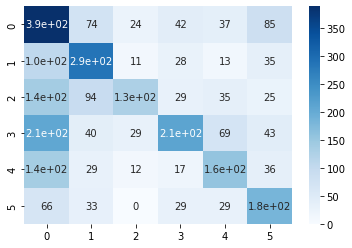

In [100]:
print(predictions_Bi11.shape)
predictions_Bi11 = predictions_Bi11.reshape(2909,6)

Corrected_Pred_Bi11 = numpy.argmax(predictions_Bi11, axis = 1)
print(Corrected_Pred_Bi11)

from sklearn.metrics import accuracy_score
print(accuracy_score(new_states_np, Corrected_Pred_Bi11))

conf_Bi11 = confusion_matrix(new_states_np, Corrected_Pred_Bi11)
sns.heatmap(conf_Bi11, annot=True, cmap='Blues')

plt.show()

(2909, 6)
[2 5 5 ... 4 1 1]
0.49398418700584396


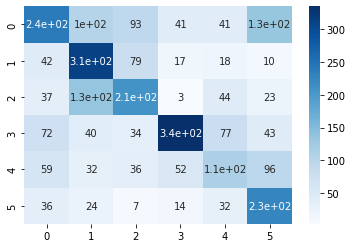

In [111]:
print(predictions_Bi12.shape)
predictions_Bi12 = predictions_Bi12.reshape(2909,6)

Corrected_Pred_Bi12 = numpy.argmax(predictions_Bi12, axis = 1)
print(Corrected_Pred_Bi12)

from sklearn.metrics import accuracy_score
print(accuracy_score(new_states_np, Corrected_Pred_Bi12))

conf_Bi12 = confusion_matrix(new_states_np, Corrected_Pred_Bi12)
sns.heatmap(conf_Bi12, annot=True, cmap='Blues')

plt.show()

(2909, 6)
[2 0 0 ... 0 0 1]
0.8989343416981781


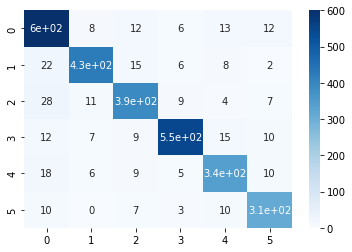

In [125]:
print(predictions_Bi13.shape)
predictions_Bi13 = predictions_Bi13.reshape(2909,6)

Corrected_Pred_Bi13 = numpy.argmax(predictions_Bi13, axis = 1)
print(Corrected_Pred_Bi11)

from sklearn.metrics import accuracy_score
print(accuracy_score(new_states_np, Corrected_Pred_Bi13))

conf_Bi13 = confusion_matrix(new_states_np, Corrected_Pred_Bi13)
sns.heatmap(conf_Bi13, annot=True, cmap='Blues')

plt.show()

(2909, 6)
[1 0 4 ... 2 1 1]
0.39841870058439327


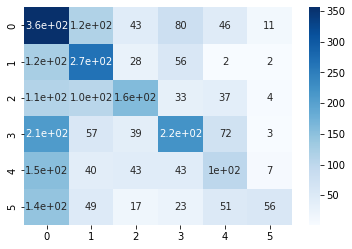

In [103]:
print(predictions_Bi14.shape)
predictions_Bi14 = predictions_Bi14.reshape(2909,6)

Corrected_Pred_Bi14 = numpy.argmax(predictions_Bi14, axis = 1)
print(Corrected_Pred_Bi14)

from sklearn.metrics import accuracy_score
print(accuracy_score(new_states_np, Corrected_Pred_Bi14))

conf_Bi14 = confusion_matrix(new_states_np, Corrected_Pred_Bi14)
sns.heatmap(conf_Bi14, annot=True, cmap='Blues')

plt.show()